In [2]:
id_ = 'tumor_uneneriched'
backup_dir = '/root/datos/maestria/netopaas/luca/data/atlas/'
net_dir = '../outputARACNE'
time = 'I-II'

# Graph Analysis

Here we we will do an analsys that focuses on seeing how the network changes from early to late lung cancer.
Also we will focus on the interaction of the immune vs tumor cells.

A draft of the analysis is here:

> Fig XX redes side-by-side
> 
> Fig XX degree distribution side-by-side (separadas inmunes y tumorales, en el mismo plot)
>
> Tabla XX: medidas globales (num nodos inmunes, num nodos tumorales, grado promedio para cada población, diámetro, num. componentes, clustering coefficient global (para bipartitas) 
>
> Fig XX: scatterplot grado vs redundancia (cuatro paneles, early, late, inmunes, tumorales)


## Libraries and Data

In [21]:
import os
import sys

from collections import Counter

sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from networkx.drawing.layout import bipartite_layout

In [18]:
# adata = sc.read_h5ad(f'{backup_dir}/{id_}.h5ad')


# if time == 'III-IV':
#     stages = ['III','III or IV', 'IV']
# else:
#     stages = ['I','II']

# adata = adata[adata.obs.uicc_stage.isin(stages)]

# adata.var['ens'] = adata.var.index
# adata.var.index = adata.var.feature_name

/tmp/ipykernel_378366/2958287070.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ens'] = adata.var.index


In [47]:
times = ['I-II', 'III-IV']
Gs = {}

for time in times:
    Gs[time] = nx.read_edgelist(f"{net_dir}/net{time}less.txt",
                                data=(("MI", float),('p', float)), delimiter='\t')


## Convert to bipartite

In [48]:
# Identify the edges to be removed
tumor_nodes_t = {}
not_tumor_nodes_t = {}
for time, G in Gs.items():
    tumor_nodes = [ node for node in list(G.nodes) if 'Tumor' in node ]
    tumor_nodes_t[time] = tumor_nodes
    edges_to_remove = [(u, v) for u in tumor_nodes for v in tumor_nodes if G.has_edge(u, v)]
    
    G.remove_edges_from(edges_to_remove)
    
    not_tumor_nodes = [ node for node in list(G.nodes) if not 'Tumor' in node ]
    not_tumor_nodes_t[time] = not_tumor_nodes
    edges_to_remove = [(u, v) for u in not_tumor_nodes for v in not_tumor_nodes if G.has_edge(u, v)]
    
    # Remove the edges from the graph
    G.remove_edges_from(edges_to_remove)


## Redes side-by-side

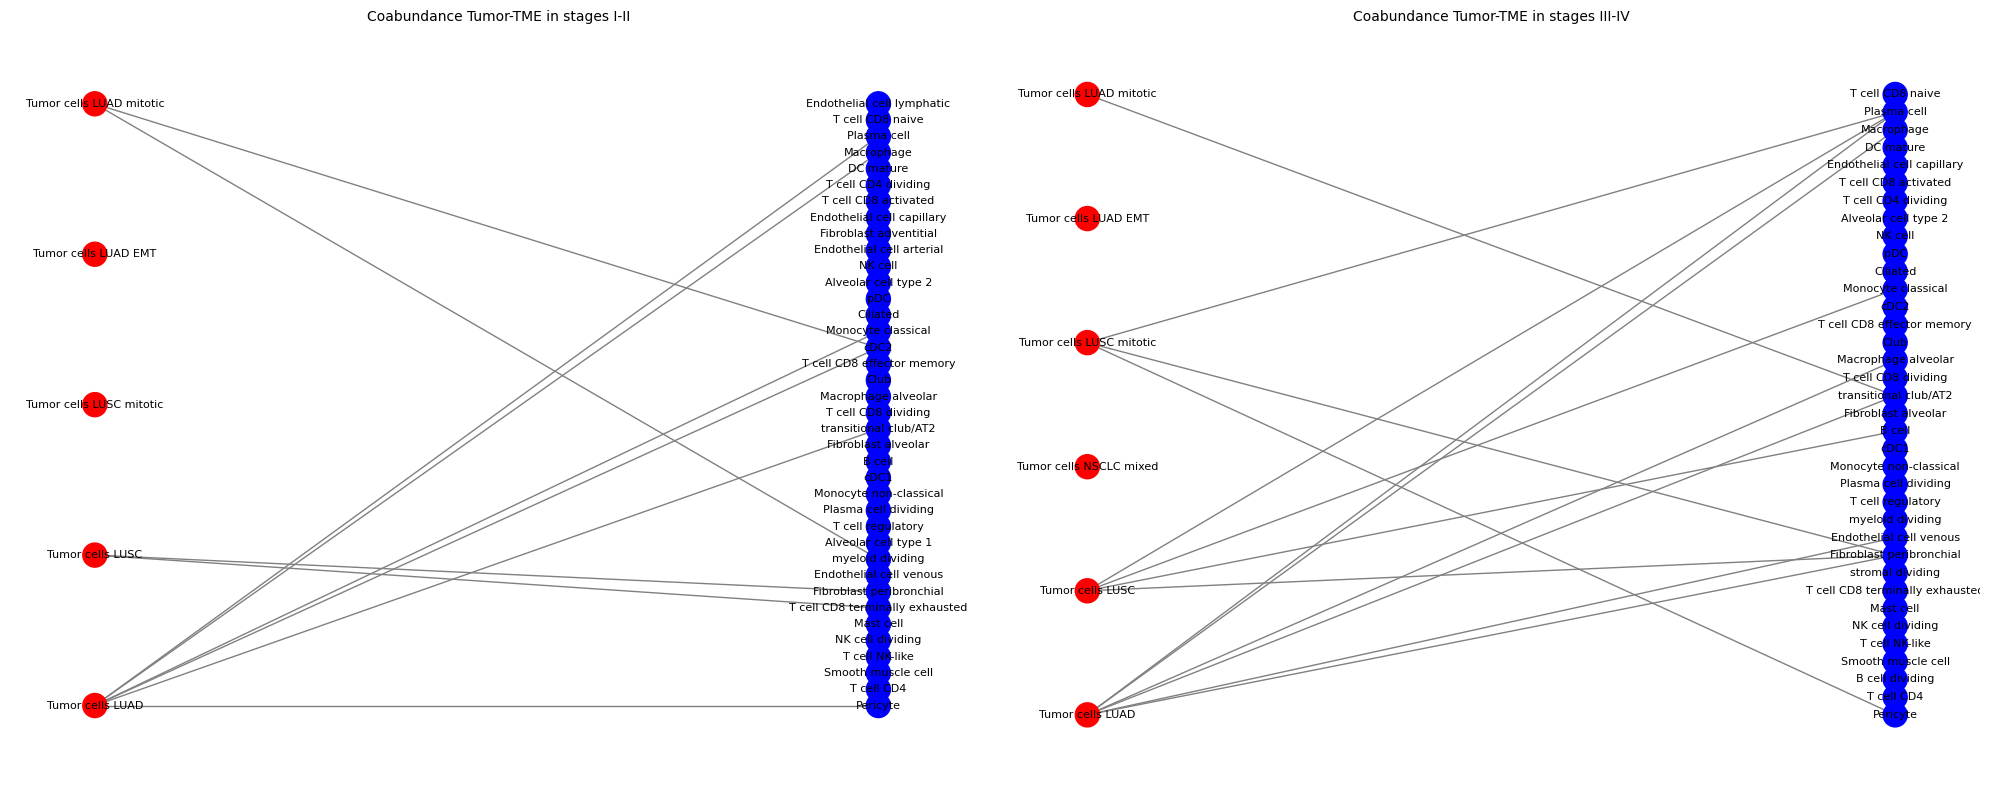

In [51]:

# Define colors for the sides of the bipartite graph
tumor_color = 'red'
tme_color = 'blue'

fig, axes = plt.subplots(1, len(times), figsize=(20, 8), sharex=True, sharey=True)

for ax, time in zip(axes, times):
    pos = bipartite_layout(Gs[time], tumor_nodes_t[time])
    
    # Assign colors to nodes
    node_colors = [tumor_color if node in tumor_nodes_t[time] else tme_color for node in Gs[time].nodes]
    
    # Draw the bipartite graph
    nx.draw(
        Gs[time], pos, with_labels=True, font_size=8, ax=ax,
        node_color=node_colors, edge_color='gray', node_size=300
    )
    
    ax.set_title(f'Coabundance Tumor-TME in stages {time}', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig(f'{net_dir}/coabundant_bipartite_all_stages.png')
plt.show()

## Degree distribution

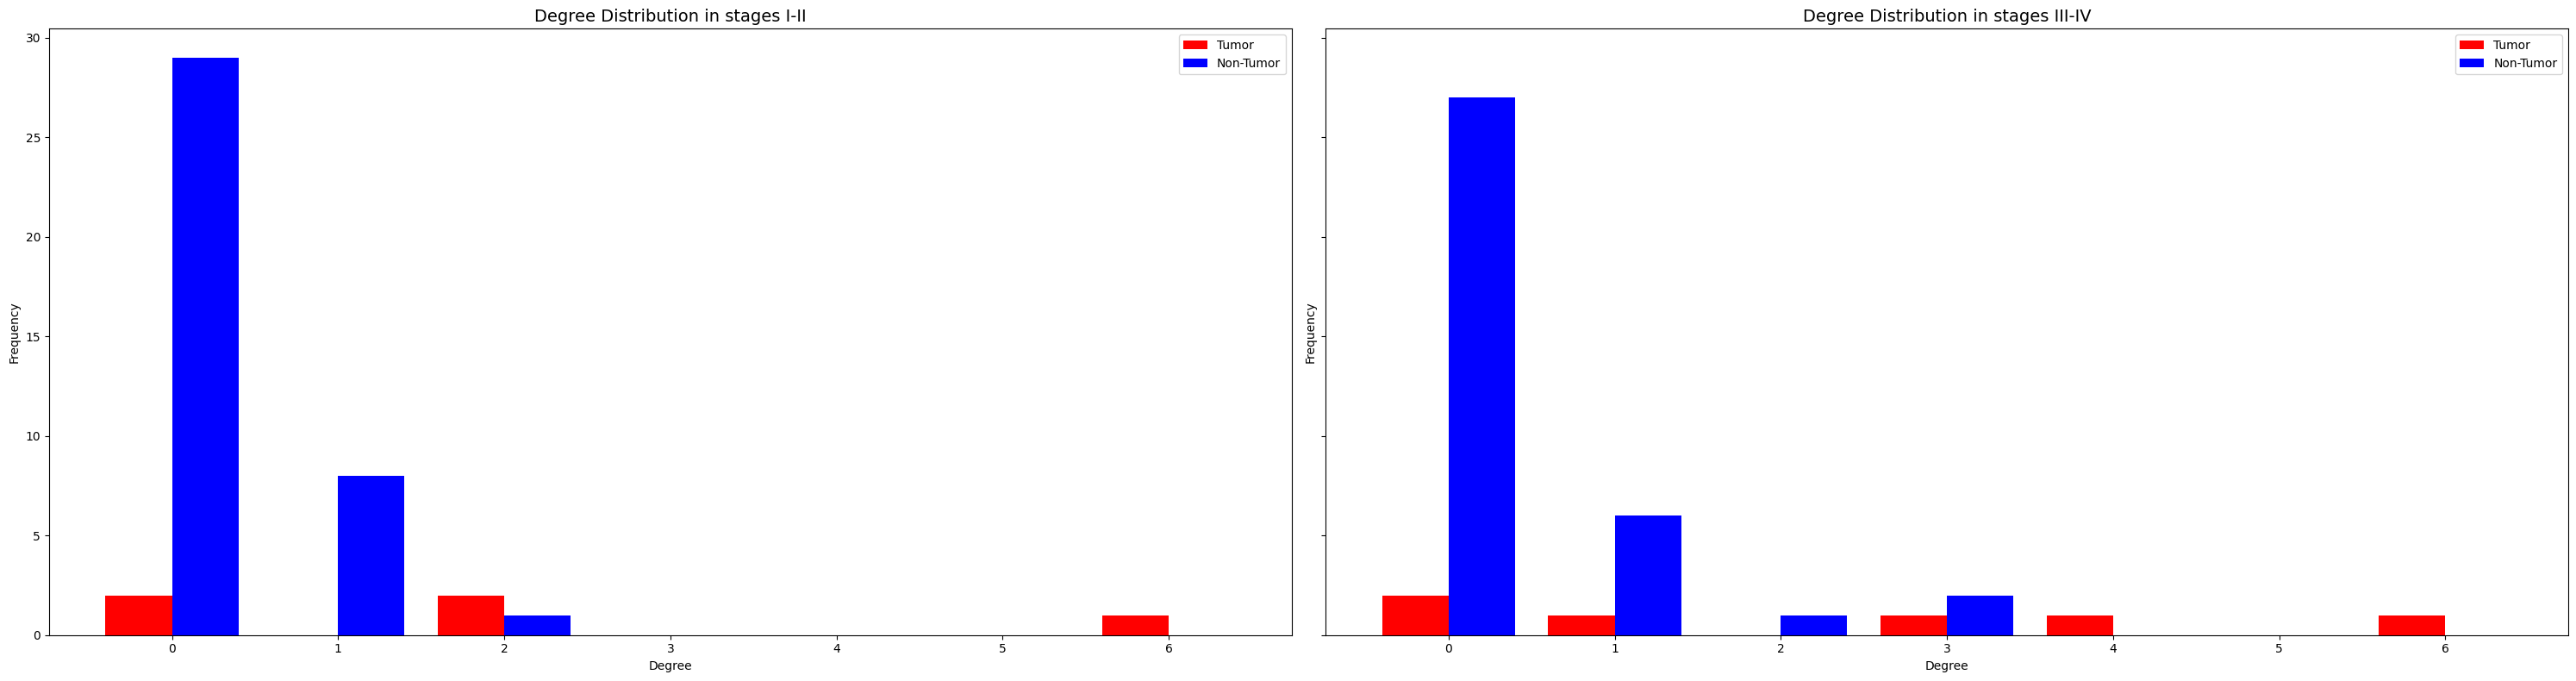

In [55]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Assume `Gs`, `tumor_nodes_t`, and `times` are already defined

fig, axes = plt.subplots(1, len(times), figsize=(15 * len(times), 8), sharey=True)

for ax, time in zip(axes, times):
    G = Gs[time]
    
    # Calculate the degree of each node
    degrees = {n: G.degree(n) for n in G.nodes()}
    
    # Separate degrees into tumor and non-tumor categories
    tumor_degrees = [degrees[n] for n in tumor_nodes_t[time]]
    nontumor_degrees = [degrees[n] for n in G.nodes() if n not in tumor_nodes_t[time]]
    
    # Count the frequency of each degree
    tumor_degree_count = Counter(tumor_degrees)
    nontumor_degree_count = Counter(nontumor_degrees)
    
    # Get sorted degrees for plotting
    all_degrees = sorted(set(tumor_degree_count.keys()).union(set(nontumor_degree_count.keys())))
    tumor_counts = [tumor_degree_count[d] for d in all_degrees]
    nontumor_counts = [nontumor_degree_count[d] for d in all_degrees]
    
    # Width of the bars
    width = 0.4
    
    # Plot the degree distribution as grouped bar plots
    ax.bar([d - width/2 for d in all_degrees], tumor_counts, width=width, color='r', label='Tumor')
    ax.bar([d + width/2 for d in all_degrees], nontumor_counts, width=width, color='b', label='Non-Tumor')
    
    ax.set_title(f"Degree Distribution in stages {time}", fontsize=14)
    ax.set_xlabel("Degree")
    ax.set_ylabel("Frequency")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.savefig(f'{net_dir}/degree_distribution_grouped_all_stages.png')
plt.show()


## Global and mezo metrics

In [59]:
import pandas as pd
import networkx as nx

# Assume `Gs`, `tumor_nodes_t`, `not_tumor_nodes_t`, and `times` are already defined

metrics = []

for time in times:
    B = Gs[time]
    
    # Get the tumor and non-tumor nodes for the current time point
    tumor_nodes = tumor_nodes_t[time]
    not_tumor_nodes = [n for n in B.nodes() if n not in tumor_nodes]
    
    # Calculate number of nodes in each population
    num_not_tumor_nodes = len(not_tumor_nodes)
    num_tumor_nodes = len(tumor_nodes)
    
    # Calculate average degree for each population
    degree_not_tumor_nodes = [B.degree(n) if isinstance(B.degree(n), int) else 0 for n in not_tumor_nodes]
    degree_tumor_nodes = [B.degree(n) if isinstance(B.degree(n), int) else 0 for n in tumor_nodes]
    avg_degree_not_tumor_nodes = sum(degree_not_tumor_nodes) / num_not_tumor_nodes if num_not_tumor_nodes > 0 else 0
    avg_degree_tumor_nodes = sum(degree_tumor_nodes) / num_tumor_nodes if num_tumor_nodes > 0 else 0
    
    # Calculate diameter (only possible if the graph is connected)
    if nx.is_connected(B):
        diameter = nx.diameter(B)
    else:
        diameter = float('inf')  # The graph is not connected, so the diameter is infinite
    
    # Calculate the number of components
    num_components = nx.number_connected_components(B)
    
    # Calculate global clustering coefficient for bipartite graphs
    global_clustering_bipartite = nx.algorithms.average_clustering(B)
    
    # Store the results
    metrics.append({
        'Time': time,
        'Num Non-Tumor Nodes': num_not_tumor_nodes,
        'Num Tumor Nodes': num_tumor_nodes,
        'Avg Degree Non-Tumor Nodes': avg_degree_not_tumor_nodes,
        'Avg Degree Tumor Nodes': avg_degree_tumor_nodes,
        'Network Diameter': diameter,
        'Num Components': num_components,
        'Global Clustering Coefficient': global_clustering_bipartite
    })

# Create a DataFrame from the metrics
df_metrics = pd.DataFrame(metrics)

# Print the DataFrame
df_metrics.set_index('Time').transpose()


Time,I-II,III-IV
Num Non-Tumor Nodes,38.000000,36.000000
Num Tumor Nodes,5.000000,6.000000
Avg Degree Non-Tumor Nodes,0.263158,0.388889
Avg Degree Tumor Nodes,2.000000,2.333333
Network Diameter,inf,inf
Num Components,33.000000,30.000000
Global Clustering Coefficient,0.000000,0.000000


## Degree vs Redundancy 

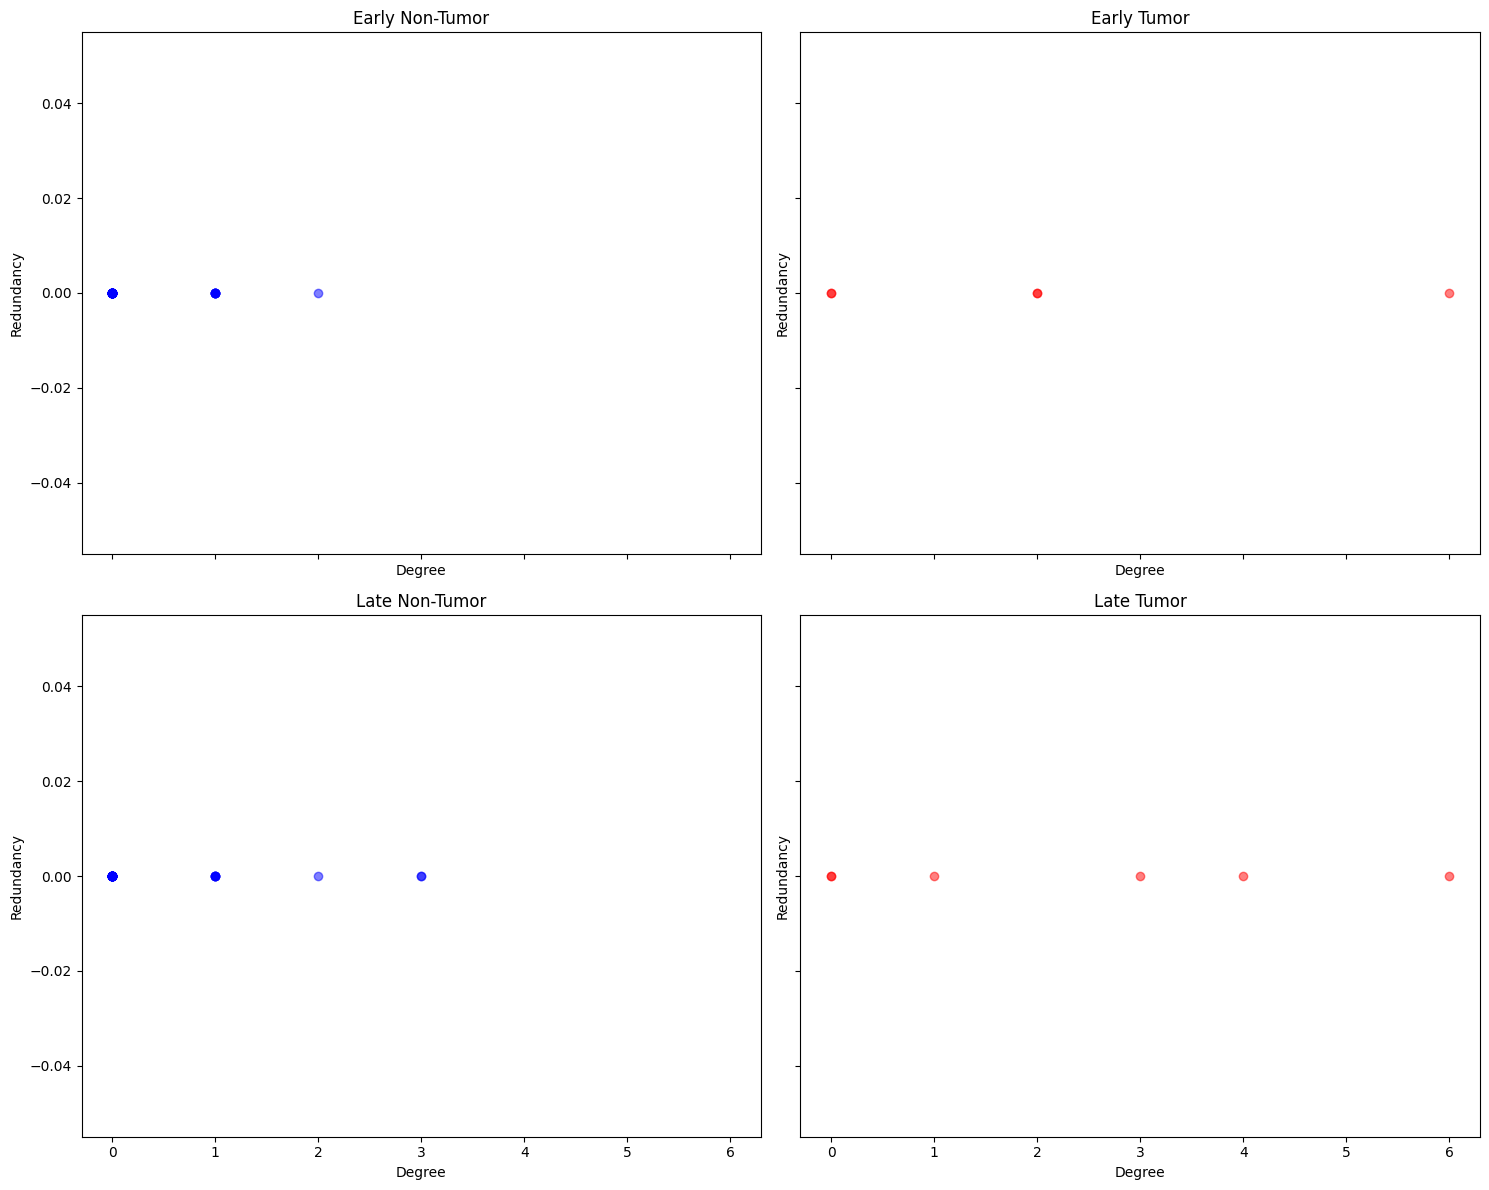

In [60]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Función para calcular la redundancia de un nodo en un grafo bipartito
def calculate_redundancy(G, node):
    neighbors = list(G.neighbors(node))
    if len(neighbors) < 2:
        return 0
    neighbor_subgraph = G.subgraph(neighbors)
    possible_edges = len(neighbors) * (len(neighbors) - 1) / 2
    actual_edges = nx.number_of_edges(neighbor_subgraph)
    return actual_edges / possible_edges if possible_edges > 0 else 0

# Suponemos que Gs, tumor_nodes_t y times ya están definidos
metrics = []

for time in times:
    B = Gs[time]
    
    # Get the tumor and non-tumor nodes for the current time point
    tumor_nodes = tumor_nodes_t[time]
    not_tumor_nodes = [n for n in B.nodes() if n not in tumor_nodes]
    
    for node in B.nodes():
        degree = B.degree(node)
        redundancy = calculate_redundancy(B, node)
        is_tumor = node in tumor_nodes
        is_early = time == 'I-II'
        metrics.append({
            'Node': node,
            'Degree': degree,
            'Redundancy': redundancy,
            'Is Tumor': is_tumor,
            'Is Early': is_early
        })

# Crear un DataFrame con las métricas
df_metrics = pd.DataFrame(metrics)

# Crear los scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

# Early Non-Tumor
early_non_tumor = df_metrics[(df_metrics['Is Early']) & (~df_metrics['Is Tumor'])]
axes[0, 0].scatter(early_non_tumor['Degree'], early_non_tumor['Redundancy'], c='blue', alpha=0.5)
axes[0, 0].set_title('Early Non-Tumor')
axes[0, 0].set_xlabel('Degree')
axes[0, 0].set_ylabel('Redundancy')

# Early Tumor
early_tumor = df_metrics[(df_metrics['Is Early']) & (df_metrics['Is Tumor'])]
axes[0, 1].scatter(early_tumor['Degree'], early_tumor['Redundancy'], c='red', alpha=0.5)
axes[0, 1].set_title('Early Tumor')
axes[0, 1].set_xlabel('Degree')
axes[0, 1].set_ylabel('Redundancy')

# Late Non-Tumor
late_non_tumor = df_metrics[(~df_metrics['Is Early']) & (~df_metrics['Is Tumor'])]
axes[1, 0].scatter(late_non_tumor['Degree'], late_non_tumor['Redundancy'], c='blue', alpha=0.5)
axes[1, 0].set_title('Late Non-Tumor')
axes[1, 0].set_xlabel('Degree')
axes[1, 0].set_ylabel('Redundancy')

# Late Tumor
late_tumor = df_metrics[(~df_metrics['Is Early']) & (df_metrics['Is Tumor'])]
axes[1, 1].scatter(late_tumor['Degree'], late_tumor['Redundancy'], c='red', alpha=0.5)
axes[1, 1].set_title('Late Tumor')
axes[1, 1].set_xlabel('Degree')
axes[1, 1].set_ylabel('Redundancy')

plt.tight_layout()
plt.show()

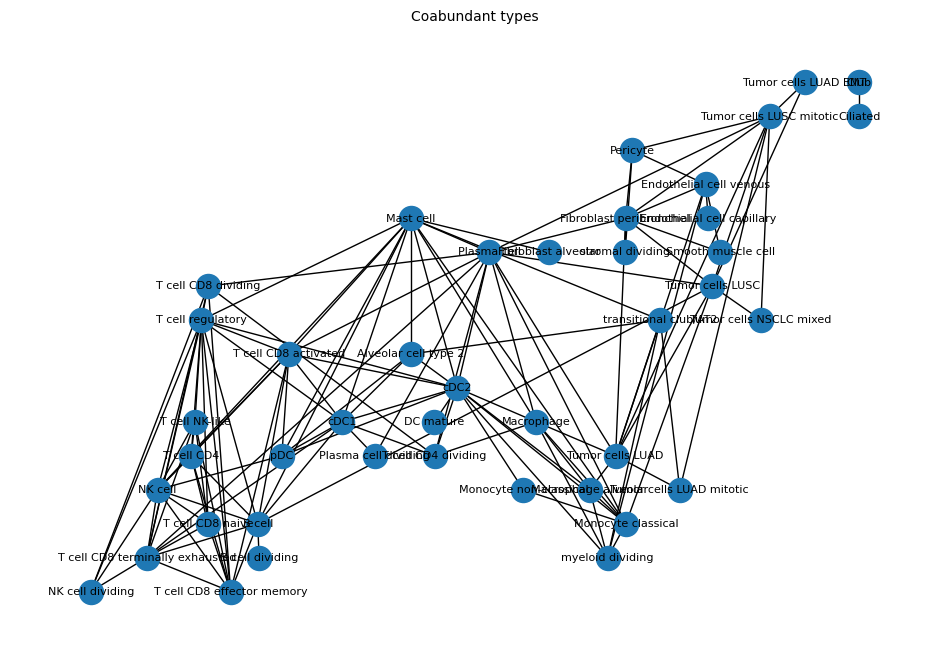

In [147]:
plt.figure(figsize=(12, 8))  # Set a larger figure size (width, height in inches)
plt.title('Coabundant types', fontsize=10)  # Smaller title font size

pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, font_size=8)  # Smaller label font size
plt.savefig(f'{aracne_dir}/coabundant_types{time}.png')